In [2]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import a_of_chi,rad_comoving_distance
from flowpm.raytracing import  lightcone_snapshots, Born, wlen
from flowpm.tfpower import linear_matter_power
import flowpm.constants as constants
import flowpm
from astropy.io import fits
from DifferentiableHOS.statistics.angular_power_tf import measure_power_spectrum_tf
import bigfile
import astropy.units as u
import astropy.constants as cnst
from lenstools.simulations.nbody import NbodySnapshot
from flowpm.io import save_state
from scipy.ndimage import gaussian_filter
import tensorflow_addons as tfa
import lenstools as lt
from astropy.cosmology import Planck15
from lenstools.simulations import DensityPlane
from DifferentiableHOS.FastPM_snapshot import FastPMSnapshot

Populating the interactive namespace from numpy and matplotlib


In [3]:
nc=64          # size of the cube, number of cells
plane_size=1024               # number of pixel for x and  y 
Boxsize=200.
field=5.
nsteps=11

In [4]:
z2a=lambda z:1. / (1. + z)
a2z = lambda a: 1/a - 1


In [26]:
def FlowPM_raytracer(nc,plane_size,box_size,field,nsteps):
    """ Computes a convergence map using ray-tracing through an N-body for a given
    set of cosmological parameters
    """
    # Instantiates a cosmology with desired parameters
    cosmology = flowpm.cosmology.Planck15()
    r = tf.linspace(0., 2000, nsteps)
    r_center = 0.5*(r[1:] + r[:-1])
    a = flowpm.tfbackground.a_of_chi(cosmology, r)
    a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
    init_stages = tf.linspace(0.1, a[-1], 4)
    # And initial conditions
    initial_conditions = flowpm.linear_field([nc, nc, 10 * nc],
                                             [box_size, box_size,
                                             10 * box_size], 
                                             lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                             batch_size=1)
    # Sample particles, using LPT up to the border of the lightcone
    # WARNING: this is probably very approximate
    state = flowpm.lpt_init(cosmology, initial_conditions,0.1)
    med_state = flowpm.nbody(cosmology, state, init_stages,[nc, nc, 10 * nc]) 
    # Perform lightcone computation and extract lens planes
    a_cen = np.concatenate([a_center.numpy(),np.array([a[-1]])])
    final_state, lps_a, lps, snaps = lightcone_snapshots(cosmology, med_state,
                                             a_cen[::-1],
                                             [nc, nc, 10 * nc],
                                             field * 60. / plane_size,
                                             plane_size)
    # Comparing density planes
    al = tf.stack(lps_a) # Array of scale factors
    rl = rad_comoving_distance(cosmology, al) # Array of comoving distances
    constant_factor = 3 / 2 * cosmology.Omega_m * (constants.H0 / constants.c)**2
    
    slice_width = box_size # Mpc/h
    density_normalization = slice_width * rl / al
    
    # This is the factor to apply to our lensplanes to make them LensTools compatible
    factor = density_normalization*constant_factor
    xgrid, ygrid = np.meshgrid(np.linspace(0,field,plane_size, endpoint=False), # range of X coordinates
                        np.linspace(0,field,plane_size, endpoint=False)) # range of Y coordinates
    coords = np.stack([xgrid, ygrid], axis=0)*u.deg
    c = coords.reshape([2, -1,1]).T
    # Now normalizing densityplane
    density=[]
    interp_im=[]
    for ind in range (10):
        dens = lps[ind][0]
        Npart = tf.reduce_sum(dens)
        dens = dens / Npart
        npix = plane_size
        dens =  dens * box_size**3 / ( (box_size/npix) * (box_size/npix) *(box_size/1) )
        im = tf.reshape(gaussian_filter(dens*factor[ind],2), [1, plane_size,plane_size,1])
        c1 = c.to(u.rad).value*rl[ind] / (box_size/npix)
        interp_im.append(tfa.image.interpolate_bilinear(im, c1))
        density.append(dens)
        
    z_lens=(1. / al) - 1.   
    # Exporting snapshots
    for i,(scale_factor, snap, comov_dist) in enumerate(zip(lps_a, snaps, r_center[::-1])):
      save_state(cosmology, snap, scale_factor, [nc, nc, nc], [box_size]*3, 'snapshot_lensing64%d'%i,
                 attrs={'comoving_distance': comov_dist})
    return lps_a, lps, rl, z_lens, interp_im, coords

In [27]:
def lenstools_raytracer(plane_size,box_size,field):
# Create a tracer object    
    tracer = lt.simulations.RayTracer(lens_type=lt.simulations.DensityPlane)
    ps = []
    for i in range(10):
        snapshot = FastPMSnapshot.open('snapshot_lensing64%d'%i)
        p,resolution,NumPart = snapshot.cutPlaneGaussianGrid(normal=2,
                                                         plane_resolution=plane_size,   
                                                         center=(1900 - i*box_size)*snapshot.Mpc_over_h,
                                                         thickness=box_size*snapshot.Mpc_over_h,
                                                         left_corner=np.zeros(3)*snapshot.Mpc_over_h,
                                                         smooth=None,
                                                         kind='density')
        p=gaussian_filter(p,2)
        
        ps.append(p)
        plane = DensityPlane(p, angle=snapshot.header["box_size"],
                                redshift=snapshot.header["redshift"],
                                cosmology=Planck15,
                                num_particles=NumPart)
        tracer.addLens(plane)
   
    tracer.addLens(lt.simulations.DensityPlane(np.zeros((128,128)),
                         angle=snapshot.header["box_size"], 
                                               redshift=1.5,
                                               cosmology=Planck15))
    
    # Make sure lenses are in the right order
    tracer.reorderLenses()
    xgrid, ygrid = np.meshgrid(np.linspace(0,field,plane_size, endpoint=False), # range of X coordinates
                        np.linspace(0,field,plane_size, endpoint=False)) # range of Y coordinates
    coords = np.stack([xgrid, ygrid], axis=0)*u.deg
    return  ps, tracer, coords


In [28]:
lps_a, lps, rl, z_lens, interp_im, coords=FlowPM_raytracer(nc,plane_size,Boxsize,field,nsteps)

In [29]:
ps, tracer, coords=lenstools_raytracer(plane_size,Boxsize,field)

In [30]:
def convergenceBorn(interp_im,rl,initial_positions,z):
    cosmo=flowpm.cosmology.Planck15()
    current_convergence = np.zeros(initial_positions.shape[1:])
    distance=rl
    last_lens=len(interp_im)
    for k in range(last_lens):
                plans=interp_im[k]
                density=plans[0,:,0].numpy().reshape([plane_size,plane_size]).T
    #Cumulate on the convergence
                current_convergence += density * (1. - (distance[k]/rad_comoving_distance(cosmo,z2a(z))))              
    return current_convergence

In [31]:
lensfit=tracer.convergenceBorn(coords,z=1.0)

In [32]:
kmap_flow=convergenceBorn(interp_im,rl,coords,1.0)

In [33]:
ell, ps_example = measure_power_spectrum_tf(tf.cast(kmap_flow,dtype=tf.complex64),field,plane_size)
l_k,Pl_k = measure_power_spectrum_tf(tf.cast(lensfit,dtype=tf.complex64),5.,plane_size)

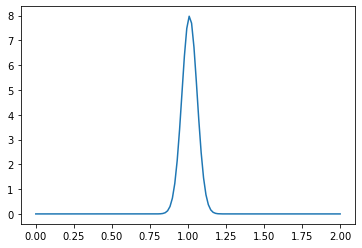

In [14]:
import jax
import jax_cosmo as jc
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
plot(zsamp, nzs_s(zsamp))

In [15]:
nzs = [nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]
elle = np.logspace(1,4) # Defines a range of \ell
cosmo_jc = jc.Planck15()
# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo_jc, elle, probes)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


# Here we use a Gaussian filter = 1 

Let's plot the 1) Convergence maps by LensTools, 2) by FlowPM, 3) the Residuals 

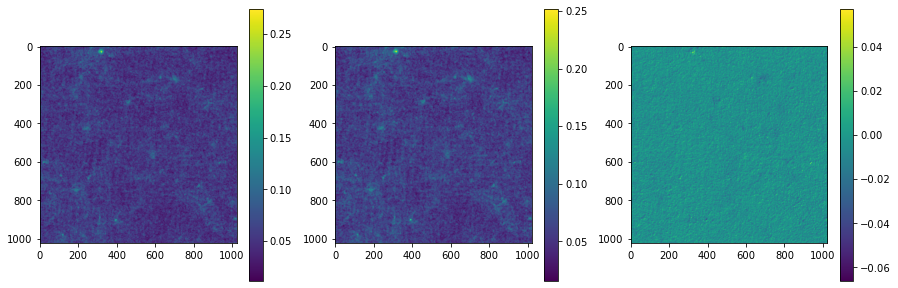

In [16]:
figure(figsize=[15,5])
subplot(131)
# This is how the kmap looks in LensTools
imshow(lensfit);colorbar()
subplot(132)
#This is how the kmap looks in FlowPM
imshow(kmap_flow);colorbar()
subplot(133)
# This is how the residuals looks 
imshow(lensfit-kmap_flow);colorbar()

Let's plot the 1) The first lens plans by LensTools, 2) by FlowPM, 3) the Residuals 

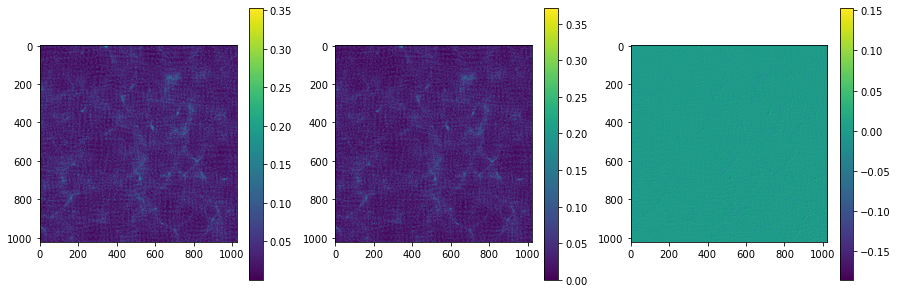

In [17]:
# + 0.5
figure(figsize=[15,5])
subplot(131)
# This is how the lensplane looks in LensTools
imshow(tracer.lens[-2].getValues(coords[0], coords[1]));colorbar()
subplot(132)
# This is how the lensplane looks in FlowPM
imshow(interp_im[0][0,:,0].numpy().reshape([plane_size,plane_size]).T);colorbar()
subplot(133)
# This is how the lensplane looks in LensTools
imshow(tracer.lens[-2].getValues(coords[0], coords[1]) -interp_im[0][0,:,0].numpy().reshape([plane_size,plane_size]).T); colorbar()

Here I compare the angular power spectrum computed from both the maps by using the Function "measure_power_spectrum_tf" implemented in TensorFlow 

Populating the interactive namespace from numpy and matplotlib


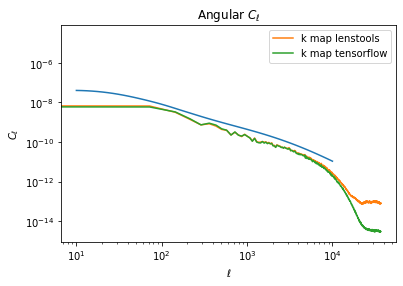

In [18]:
%pylab inline 
loglog(elle, cls[0])
loglog(l_k,Pl_k ,label='k map lenstools') #here the ps is computed by  using our function 
loglog(ell, ps_example, label='k map tensorflow')
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
legend()
title(r'Angular $C_\ell$');

Let's export the convergence maps devolped by LensTools 

In [20]:
cosmo= flowpm.cosmology.Planck15()

In [21]:
c1 = fits.Card('H0', constants.H0, 'Hubble constant in km/s/( h^{-1} Mpc)')  
c2 = fits.Card('hierarch h', cosmo.h.numpy(), 'Unitless Hubble constant ')  
c3=fits.Card('W0', cosmo.w0.numpy(), 'First order term of dark energy equation')
c4=fits.Card('WA', cosmo.wa.numpy(), 'Second order term of dark energy equation of state')
c5=fits.Card('Z', 1.00, ' Redshift of the background sources ')
c6=fits.Card('ANGLE', 5., 'Side angle in degrees  ')
c7=fits.Card('OMEGA_M', cosmo.Omega_c.numpy(), ' Dark Matter density')
c8=fits.Card('OMEGA_L', cosmo.Omega_de.numpy(), 'Dark Energy density ')
c9=fits.Card('ITYPE', 'ConvergenceMap', 'Image type ')
hdu = fits.PrimaryHDU(lensfit)
for i in range(1,10):
    exec(f'hdu.header.append(c{i})')
hdul = fits.HDUList([hdu])
hdul.writeto('kmap_lenstools.fits')

Here I compare the angular power spectrum computed from both the maps by using the Function "measure_power_spectrum_tf" implemented in TensorFlow and the Function by Lenstools respectively 

In [22]:
from lenstools import ConvergenceMap
test_kmap= ConvergenceMap.load('/Users/dl264294/Desktop/github/DifferentiableHOS/notebooks/kmap_lenstools.fits')
l,Pl = test_kmap.powerSpectrum(ell)

Populating the interactive namespace from numpy and matplotlib


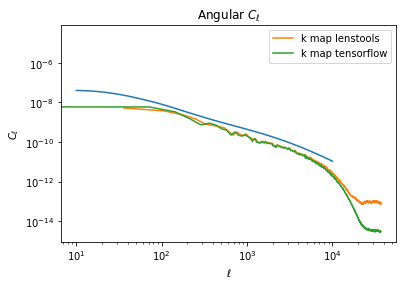

In [24]:
%pylab inline 
loglog(elle, cls[0])
loglog(l,Pl ,label='k map lenstools')#here the ps is computed by  using LensTools function 
loglog(ell, ps_example, label='k map tensorflow')
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
legend()
title(r'Angular $C_\ell$');

# Here we use a Gaussian filter = 2 

Let's plot the 1) Convergence maps by LensTools, 2) by FlowPM, 3) the Residuals 

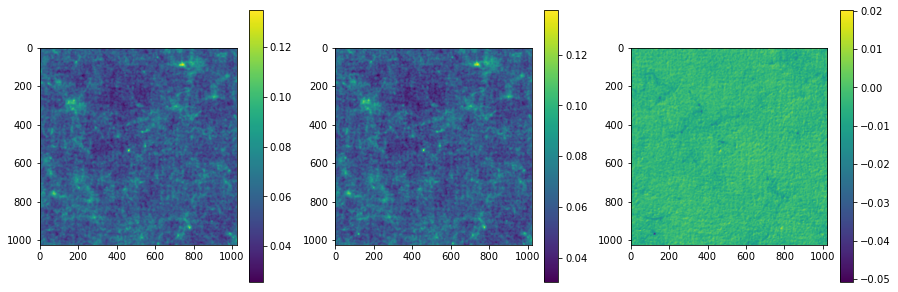

In [34]:
#Convergence maps

figure(figsize=[15,5])
subplot(131)
# This is how the kmap looks in LensTools
imshow(lensfit);colorbar()
subplot(132)
#This is how the kmap looks in FlowPM
imshow(kmap_flow);colorbar()
subplot(133)
# This is how the residuals looks 
imshow(lensfit-kmap_flow);colorbar()

Let's plot the 1) The first lens plans by LensTools, 2) by FlowPM, 3) the Residuals 

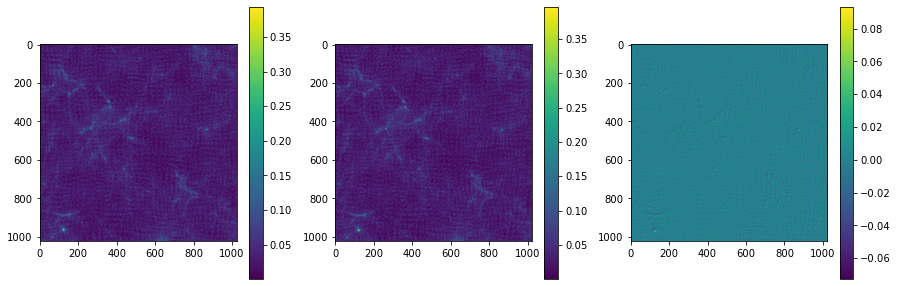

In [35]:
# + 0.5
figure(figsize=[15,5])
subplot(131)
# This is how the lensplane looks in LensTools
imshow(tracer.lens[-2].getValues(coords[0], coords[1]));colorbar()
subplot(132)
# This is how the lensplane looks in FlowPM
imshow(interp_im[0][0,:,0].numpy().reshape([plane_size,plane_size]).T);colorbar()
subplot(133)
# This is how the residuals looks 
imshow(tracer.lens[-2].getValues(coords[0], coords[1]) -interp_im[0][0,:,0].numpy().reshape([plane_size,plane_size]).T); colorbar()

Here I compare the angular power spectrum computed from both the maps by using the Function "measure_power_spectrum_tf" implemented in TensorFlow 

Populating the interactive namespace from numpy and matplotlib


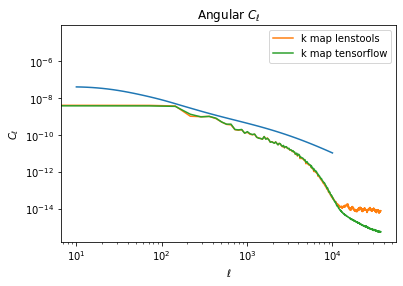

In [36]:
%pylab inline 
loglog(elle, cls[0])
loglog(l_k,Pl_k ,label='k map lenstools')
loglog(ell, ps_example, label='k map tensorflow')
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
legend()
title(r'Angular $C_\ell$');